In [1]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

#### Neural ODE

In [2]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out


In [124]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, domain, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(input_dim, hidden_layers, depth, output_dim*(num_breakpoints+1), activation_func)

        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = input_dim
        self.num_breakpoint     = num_breakpoints
        self.domain             = domain
        self.num_A              = (num_breakpoints+1)*output_dim
        self.breakpoints        = torch.linspace(domain[0], domain[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(torch.tensor([2.0]))#nn.Parameter(self.breakpoints[1:-1])
    

    def sigmoid_rescaled(self, x):
        a = 1 + torch.exp(-50*x)
        c = 1/a
        return c

    def forward(self, t, x):
        out = self.network(x)

        #Getting indicator function
        #index = torch.where(self.break_params < t)[0].shape[0]
        #indicator = torch.concatenate([ torch.sigmoid(self.break_params - t)*((t < self.break_params).float()), torch.sigmoid(t - self.break_params)*((t > self.break_params).float())])
        a = torch.sigmoid(self.break_params - t)*((t < self.break_params).float())
        b = torch.sigmoid(t - self.break_params)*((t > self.break_params).float())
        print(a.shape)
        indicator = torch.concatenate([a , b])
        #print(indicator); print('Break Param:', self.break_params)
        out2 = out*indicator
        
        

        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)

        return final_out
    
  

#### Model

In [125]:
class SaddleNodeStable:
    def __init__(self, a, b, r):
        #Setting system parameters
        self.a = a
        self.r = r
        self.b = b

    #Differential Equation
    def f(self, t, x):
        xdot = -(x-self.a)*((x-self.b)**2 + self.r(t) )

        return np.array(xdot)

In [126]:
t_crit = 3.0
def parameter_f(t):
        if t <= t_crit: 
                return -0.5
        elif t > t_crit:
                return 1
   

In [127]:
saddlenode = SaddleNodeStable(a = 0.1, b = 1, r = parameter_f)

##### Solve IVP

In [128]:
tstart = 0; tfinal =10; dt = 0.01; t_eval = np.arange(tstart, tfinal, dt)

In [129]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y


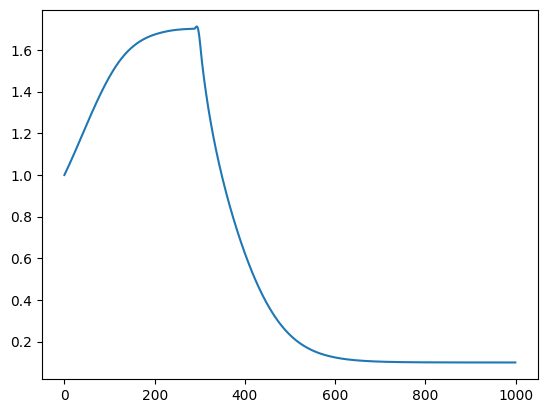

In [130]:
plt.plot(data1[0, :])

#### Training 

In [131]:
#Batching function
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        
data1_tensor = torch.tensor(data1)
t_eval_tensor = torch.tensor(t_eval)

##### Model Parameters

In [132]:
model = Piecewise_Auto_NODE(input_dim=1, hidden_layers=2, depth = 15, output_dim=1, domain = [0, 10], num_breakpoints=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [133]:
print(model)

Piecewise_Auto_NODE(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [134]:
loss_list = []
batch_length = 80; batch_size = 5
init = 1

In [135]:
pred_x = odeint(func = model, y0 = torch.tensor([2.0]), t = torch.arange(0, 10, 0.01), method='rk4', options={'step_size': 0.01})

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

In [ ]:
torch.autograd.set_detect_anomaly(False)

: 

##### Training Loop

In [85]:
a = model(t=torch.tensor([2.0]), x=torch.tensor([3.0]))


###### Single Training Step 

In [120]:
optimizer.zero_grad()
pred_x = odeint(model, torch.tensor([1.0]).float(), t_eval_tensor.float(), method='rk4', options={'step_size': 0.01})
train_loss = loss_fn(pred_x, data1_tensor.T.float())

In [121]:
train_loss.backward()
optimizer.step()

In [122]:
print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(1.4600, grad_fn=<MseLossBackward0>)

Breakpoint:  Parameter containing:
tensor([2.0100], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0258])


In [123]:
model

Piecewise_Auto_NODE(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)

###### Main Loop

In [103]:
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data1_tensor.T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0], batch_time_i, method='rk4', options={'step_size': 0.01})

        #Calculating loss
        loss = loss_fn(pred_x, torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model, torch.tensor([1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x, data1_tensor.T)
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_4680\2699434942.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x, torch.tensor(batch_i))
  0%|          | 1/5000 [00:05<6:59:42,  5.04s/it]

Epoch 0, Loss: 0.001241211636884615


  2%|▏         | 101/5000 [03:11<2:54:58,  2.14s/it]

Epoch 100, Loss: 0.00016396849430556763


  4%|▍         | 201/5000 [06:13<2:55:37,  2.20s/it]

Epoch 200, Loss: 0.00032820484150432327


  6%|▌         | 301/5000 [09:16<2:50:35,  2.18s/it]

Epoch 300, Loss: 0.00019685461816617037


  8%|▊         | 401/5000 [12:23<2:39:03,  2.08s/it]

Epoch 400, Loss: 0.0006872978150816243


 10%|█         | 501/5000 [15:27<2:44:05,  2.19s/it]

Epoch 500, Loss: 0.00026673073945689374


 12%|█▏        | 601/5000 [18:34<2:37:05,  2.14s/it]

Epoch 600, Loss: 0.002014759093524777


 14%|█▍        | 701/5000 [21:34<2:39:02,  2.22s/it]

Epoch 700, Loss: 0.0002454691348676505


 16%|█▌        | 801/5000 [24:45<2:30:35,  2.15s/it]

Epoch 800, Loss: 0.0006142455219512589


 18%|█▊        | 901/5000 [27:45<2:20:31,  2.06s/it]

Epoch 900, Loss: 0.00024343509384349506


 20%|██        | 1001/5000 [30:43<2:17:02,  2.06s/it]

Epoch 1000, Loss: 0.0010596833430827777


 22%|██▏       | 1101/5000 [33:42<2:12:34,  2.04s/it]

Epoch 1100, Loss: 0.0008301190152776532


 24%|██▍       | 1201/5000 [36:35<2:08:11,  2.02s/it]

Epoch 1200, Loss: 0.004535340132801939


 26%|██▌       | 1301/5000 [39:43<2:10:25,  2.12s/it]

Epoch 1300, Loss: 0.00013737258363980237


 28%|██▊       | 1401/5000 [42:53<2:12:10,  2.20s/it]

Epoch 1400, Loss: 0.0006322691333983585


 30%|███       | 1501/5000 [45:56<2:02:35,  2.10s/it]

Epoch 1500, Loss: 0.0010862866546653132


 30%|███       | 1521/5000 [46:34<1:46:31,  1.84s/it]


KeyboardInterrupt: 

##### Analysis

In [105]:
pred_x = odeint(model, torch.tensor([1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})

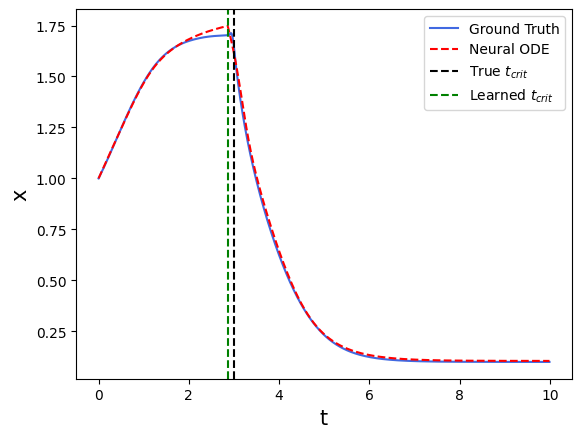

In [106]:
plt.plot(t_eval, data1[0, :], color='royalblue', label = 'Ground Truth')
plt.plot(t_eval,  pred_x.detach().numpy(), color='r', linestyle='--', label='Neural ODE')
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.axvline(x = t_crit, color='k', linestyle='--', label='True '+r'$t_{crit}$')
plt.axvline(x = model.break_params.detach().numpy(), color='green', linestyle='--', label='Learned '+r'$t_{crit}$')
plt.legend()

In [191]:
model.break_params


Parameter containing:
tensor([6.9829], requires_grad=True)

In [163]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y

In [164]:
def sigmoid_rescaled(x):
    a = 1 + torch.exp(-50*x)
    c = 1/a
    return c

In [165]:
x= torch.tensor([-0.5])
print(torch.sigmoid(x))
print(sigmoid_rescaled(x))

tensor([0.3775])
tensor([1.3888e-11])


In [13]:
time = torch.arange(-20, 20, 0.01)

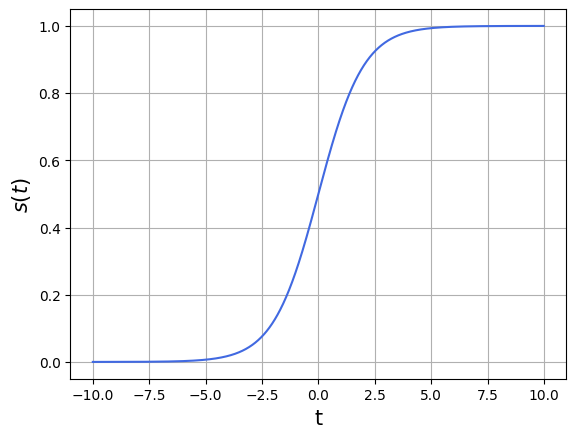

In [43]:
time = torch.arange(-10, 10, 0.01)
plt.plot(time, torch.sigmoid(time), color='royalblue')
plt.xlabel('t', fontsize = 15)
plt.ylabel(r'$s(t)$', fontsize = 15)
plt.grid(visible=True)

In [30]:
time = torch.arange(0, 20, 0.01)
p1 = 5
p2 = 10
k = 4
def sigmoid_rescale_custom(t):
    a = torch.sigmoid(k*(t - p1))
    b = torch.sigmoid(k*(p2 - t))
    return a*b

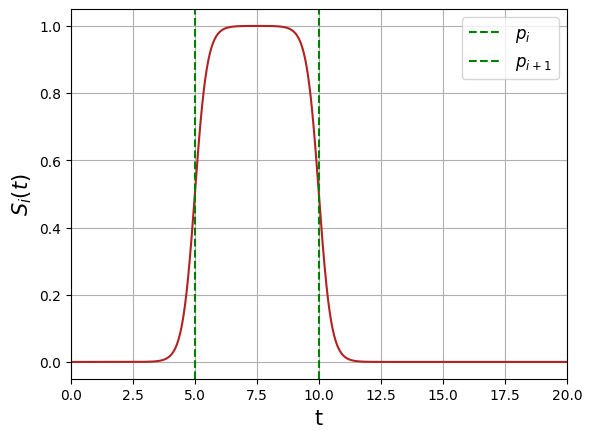

In [41]:
plt.plot(time, sigmoid_rescale_custom(time), color='firebrick')
plt.xlabel('t', fontsize = 15)
plt.ylabel(r'$S_i(t)$', fontsize = 15)
plt.xlim(0, 20)
plt.axvline(x=p1, color='g', linestyle='--', label = r'$p_{i}$')
plt.axvline(x=p2, color='g', linestyle='--', label = r'$p_{i+1}$')
plt.legend(fontsize = 12)
plt.grid(visible=True)

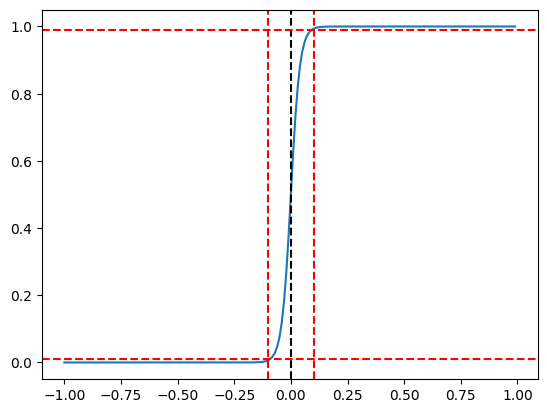

In [126]:
#plt.plot(time, torch.sigmoid(time))
plt.plot(time, sigmoid_rescaled(time))
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0.01, color='r', linestyle='--')
plt.axhline(y=0.99, color='r', linestyle='--')

plt.axvline(x=-0.1, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')